In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re

# Project's package
import sys
try:
    session_params is not None 
    sys.path.append("../auimpy")
    import prepair, air
except NameError:
    session_params = {
    'filters_applied': True, 
    'minimal_accuracy': 60,
    'write_text': True,
    'save_figs': True,
    'input_method': 'mouse',
    'paper_name': 'Exp. 4'
    }
    sys.path.append("../auimpy")
    import prepair, air

data = pd.read_csv('input/exp4 - ia_middle_irrelevant.csv', encoding='utf-8')
demog = pd.read_csv('./input/demog.csv')

In [2]:
# Data for 56 / 59 subjects. 
print(demog.loc[demog['que'] == 'age', 'resp'].astype(int).describe())
print(demog.loc[demog['que'] == 'sex', 'resp'].value_counts(normalize=True))
print(demog['participant'].unique().shape[0])

count    58.000000
mean     23.120690
std       4.292293
min      18.000000
25%      20.000000
50%      23.000000
75%      25.000000
max      41.000000
Name: resp, dtype: float64
2    0.706897
1    0.293103
Name: resp, dtype: float64
56


In [3]:
# Pre-Processing:
# Non-Unique participant numbers have to be factorized (in conjunction with date)
data['participant'] = data['participant'].astype(str).str.cat(data['date'].values, sep="_").astype('category').cat.codes.values

# Drop rows for non-experimental trials (practice, breaks, etc.). Also drop subjects from pilots (Participant 999 etc.)
data = (
    data[~pd.isna(data[[x for x in data.columns if re.search("^exp_block.*thisN$", x)]].idxmax(axis=1))
        ].loc[data['participant'] < 99]
)
data['trial'] = data.groupby('date')['date'].cumcount()

# Multiply by 1000 because it is in seconds and not in millisecs
data.drop(labels=['rt'], axis=1, inplace=True)
# set missing responses to be nan
data[data.filter(like='rt_').columns] = data.filter(like='rt_').replace(
    {0: np.nan}).values
#subtract jitter
data['rt'] = data.filter(like='rt_').min(axis=1).subtract(
    data['jitter'], axis='index') 


# Find RT on trial
data['rt'] = data['rt'].values * 1000 

# Error in coding - we had to remap the middle to the ring finger
data['correct_finger'] = data['number'].map({1: 'index', 2: 'ring'}).values
data.loc[data['handLaterality'] == "L", 'correct_finger'] = (
    data.loc[data['handLaterality'] == "L", 'number'].map(
        {1: 'ring', 2: 'index'}).values)

# Find finger of reseponse 
data['resp_finger'] = data.filter(like='rt_').idxmax(
    axis=1).replace({'rt_left': 'index', 'rt_middle': 'middle', 'rt_right': 'ring'})

# Modify for left-handed participants
data.rename(columns={'handLaterality': 'hand'}, inplace=True)
data.loc[data['hand'] == "L", ['resp_finger']]  = (
    data.loc[data['hand'] == 'L', ['resp_finger']].replace(
    {'index': 'ring', 'ring': 'index'}).values
             )

data['correct'] = (data['correct_finger'] == data['resp_finger'])
data['condition'] = data['cond'].str.title().values

data = data.drop(columns=[i for i in data.columns if i not in 
                          ['participant', 'date', 'rt', 'resp_finger',
                           'correct', 'distractor_finger', 'number', 'hand', 
                          'correct_finger', 'condition']])

# Place-holder since no keys at start were simply written down as negative RT
data['keys_at_start'] = '[1, 0, 1]'

data.rename(columns={'number': 'cuenumber'}, inplace=True)
data['cuenumber'] = data['cuenumber'].map({1: 'Index', 2: 'Ring'}).values

In [4]:
prpr = prepair.PrepAIR(data=data, **session_params)

In [5]:
prpr.report_invalid_trials()

'Invalid trials included incorrect or omitted responses (6.82%), slow responses (>950ms, 2.77%) fast responses (<150ms, 0.43%), and trials in which participants did not press the keys down correctly in the beginning of the trial (0.0%). Finally, all data from 4 participants (<60% valid trials, 6.78% of 59) were removed. Total filtration amounted to 13.08%.'

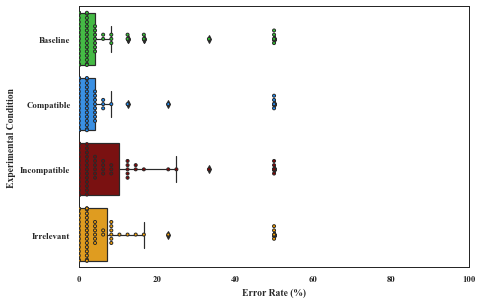

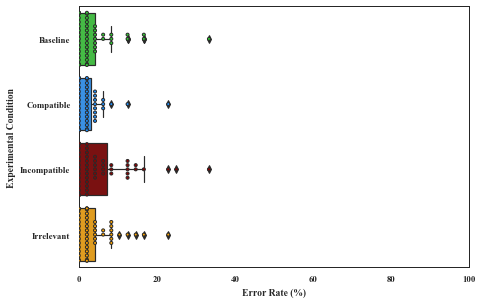

In [6]:
# Pre filteration
prpr.plot_descriptives('er', by_condition=True, pre_filteration=True)
# Post filteration
prpr.plot_descriptives('er', by_condition=True, pre_filteration=False)

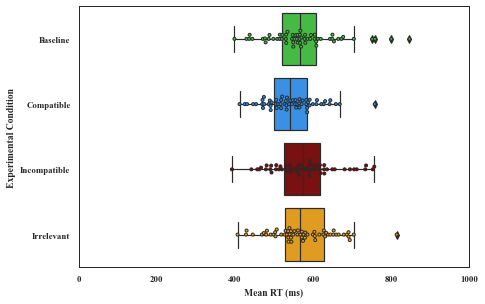

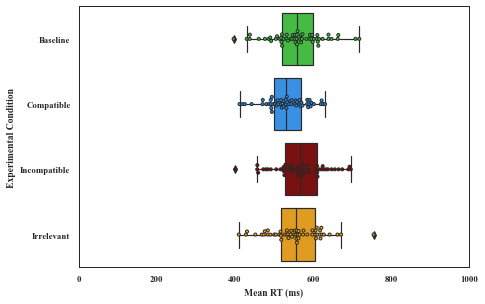

In [7]:
# Pre filteration
prpr.plot_descriptives('rt', by_condition=True, pre_filteration=True)
# Post filteration
prpr.plot_descriptives('rt', by_condition=True, pre_filteration=False)

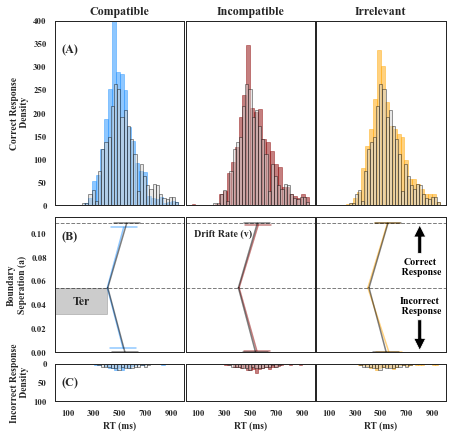

In [8]:
prpr.plot_diffusion()

In [9]:
*dfs, summary = prpr.get_finalized_data()
summary

,Mean Response Time,Error Rate,Drift Rate,Boundary Separation,Non-Decision Time
Condition (n = 55),,,,,
Baseline,558.96 (66.57),3.45 (5.77),0.342 (0.074),0.108 (0.016),408.02 (57.58)
Compatible,533.59 (51.55),2.31 (3.8),0.385 (0.072),0.102 (0.013),404.71 (46.28)
Incompatible,566.83 (64.89),5.3 (7.1),0.314 (0.077),0.106 (0.018),413.6 (60.38)
Irrelevant,554.94 (65.37),3.67 (4.74),0.329 (0.068),0.109 (0.014),399.05 (56.03)


In [10]:
rep = air.AIR(*dfs, **session_params)

C:\Users\Eitan Hemed\.conda\envs\pyr_env\lib\site-packages\rpy2\robjects\pandas2ri.py:67: UserWarning: Error while trying to convert the column "index". Fall back to string conversion. The error is: Conversion 'py2ri' not defined for objects of type '<class 'pandas.core.series.Series'>'
  (name, str(e)))
C:\Users\Eitan Hemed\.conda\envs\pyr_env\lib\site-packages\rpy2\robjects\pandas2ri.py:67: UserWarning: Error while trying to convert the column "participant". Fall back to string conversion. The error is: Conversion 'py2ri' not defined for objects of type '<class 'pandas.core.series.Series'>'
  (name, str(e)))
C:\Users\Eitan Hemed\.conda\envs\pyr_env\lib\site-packages\rpy2\robjects\pandas2ri.py:67: UserWarning: Error while trying to convert the column "condition". Fall back to string conversion. The error is: Conversion 'py2ri' not defined for objects of type '<class 'pandas.core.series.Series'>'
  (name, str(e)))
C:\Users\Eitan Hemed\.conda\envs\pyr_env\lib\site-packages\rpy2\robjects

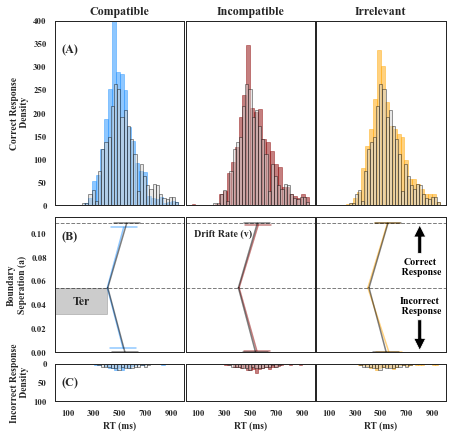

In [11]:
prpr.plot_diffusion()

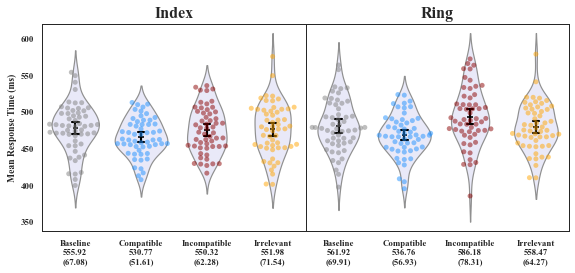

In [12]:
rep.plot_rt_by_fingers()

Repeated-Measures ANOVA showed a significant effect of experimental condition on Mean Response Time [F(2, 104) = 43.11, p < 0.001, Partial-η Squared = 0.444]
The Compatible condition Lower-tail t(54) = -6.59, p < 0.001, Mean Response Time Change -25.38ms, Cohen's d = -0.90 95%-CI [-1.21, -0.58], BF1:0 = 1347273.110
The Incompatible condition Upper-tail t(54) = 2.55, p = 0.007, Mean Response Time Change 7.86ms, Cohen's d = 0.35 95%-CI [0.07, 0.62], BF1:0 = 5.500
The Irrelevant condition Two-tail t(54) = -1.15, p = 0.256, Mean Response Time Change -4.02ms, Cohen's d = -0.16 95%-CI [-0.42, 0.11], BF1:0 = 0.270


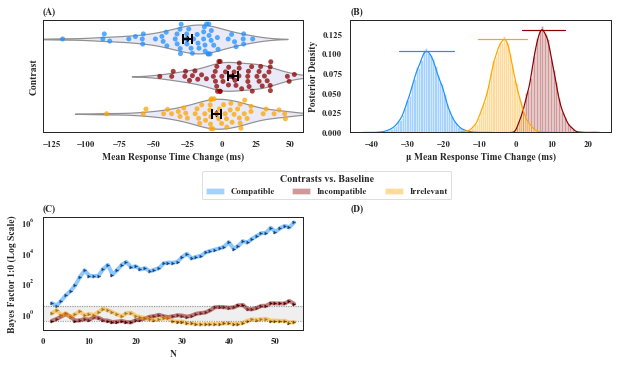

In [13]:
rep.report_results('rt')

Repeated-Measures ANOVA showed a significant effect of experimental condition on Error Rate [F(2, 87) = 8.20, p = 0.001, Partial-η Squared = 0.132]
The Compatible condition Lower-tail t(54) = -2.61, p = 0.006, Error Rate Change -1.14%, Cohen's d = -0.35 95%-CI [-0.63, -0.08], BF1:0 = 6.300
The Incompatible condition Upper-tail t(54) = 2.06, p = 0.022, Error Rate Change 1.86%, Cohen's d = 0.28 95%-CI [0.01, 0.55], BF1:0 = 2.010
The Irrelevant condition Two-tail t(54) = 0.40, p = 0.694, Error Rate Change 0.23%, Cohen's d = 0.05 95%-CI [-0.21, 0.32], BF1:0 = 0.160


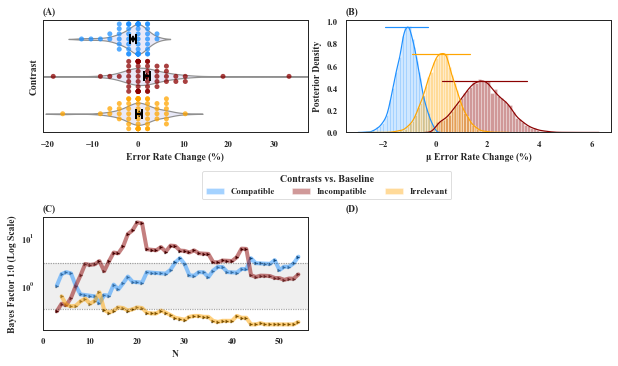

In [14]:
rep.report_results('er')

Repeated-Measures ANOVA showed a significant effect of experimental condition on Drift Rate [F(2, 102) = 41.46, p < 0.001, Partial-η Squared = 0.434]
The Compatible condition Upper-tail t(54) = 6.37, p < 0.001, Drift Rate Change 0.0433v, Cohen's d = 0.87 95%-CI [0.55, 1.18], BF1:0 = 625368.160
The Incompatible condition Lower-tail t(54) = -3.18, p = 0.001, Drift Rate Change -0.0279v, Cohen's d = -0.43 95%-CI [-0.71, -0.15], BF1:0 = 24.900
The Irrelevant condition Two-tail t(54) = -1.58, p = 0.119, Drift Rate Change -0.0126v, Cohen's d = -0.21 95%-CI [-0.48, 0.05], BF1:0 = 0.470


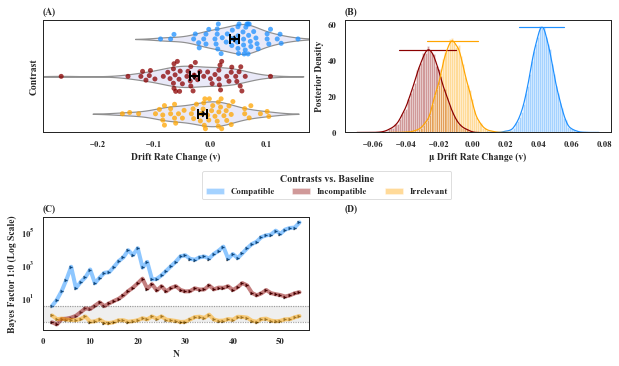

In [15]:
rep.report_results('drift_rate')

Repeated-Measures ANOVA showed a significant effect of experimental condition on Boundary Separation [F(2, 99) = 5.05, p = 0.010, Partial-η Squared = 0.086]
The Compatible condition Lower-tail t(54) = -3.01, p = 0.002, Boundary Separation Change -0.0066a, Cohen's d = -0.41 95%-CI [-0.68, -0.13], BF1:0 = 16.330
The Incompatible condition Upper-tail t(54) = -1.01, p = 0.841, Boundary Separation Change -0.0025a, Cohen's d = -0.14 95%-CI [-0.40, 0.13], BF1:0 = 0.080
The Irrelevant condition Two-tail t(54) = 0.22, p = 0.825, Boundary Separation Change 0.0004a, Cohen's d = 0.03 95%-CI [-0.23, 0.29], BF1:0 = 0.150


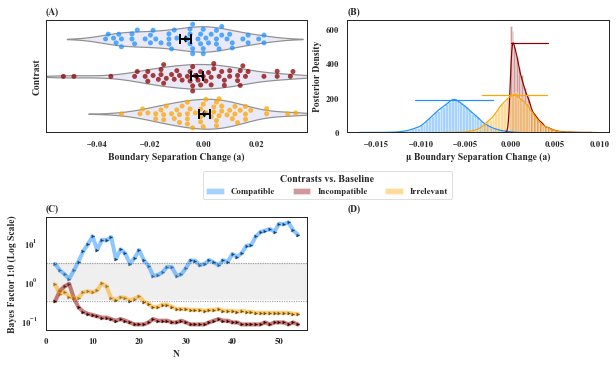

In [16]:
rep.report_results('boundary_separation')

Repeated-Measures ANOVA showed a significant effect of experimental condition on Non-Decision Time [F(2, 97) = 5.65, p = 0.006, Partial-η Squared = 0.095]
The Compatible condition Lower-tail t(54) = -0.77, p = 0.224, Non-Decision Time Change -0.0033s, Cohen's d = -0.10 95%-CI [-0.37, 0.16], BF1:0 = 0.300
The Incompatible condition Upper-tail t(54) = 1.54, p = 0.065, Non-Decision Time Change 0.0056s, Cohen's d = 0.21 95%-CI [-0.06, 0.47], BF1:0 = 0.830
The Irrelevant condition Two-tail t(54) = -2.29, p = 0.026, Non-Decision Time Change -0.0090s, Cohen's d = -0.31 95%-CI [-0.58, -0.04], BF1:0 = 1.600


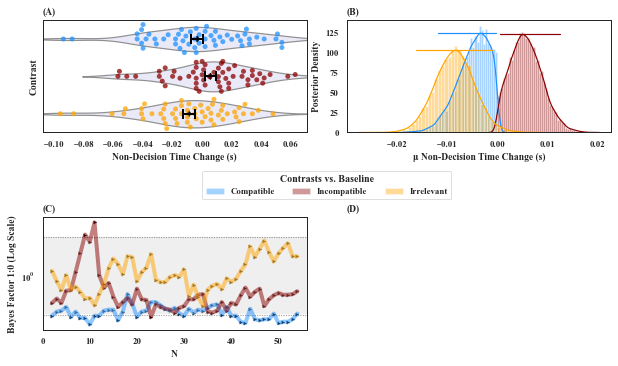

In [17]:
rep.report_results('non_decision_time')